# Preliminaries


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/Colab Notebooks/homework


/gdrive/My Drive/Colab Notebooks/homework


In [4]:
#we import all of the libraries we may need
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [5]:
#set an equal random seed for all the random generations
seed = 1602 #a number i like :)

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Utility Functions


In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

In [7]:
# the function given by lattari that generates a callback that uses ModelCheckpoint to save last and best weights 
#and TensorBoards to save some metrics during training
#caps lock comments are the ones i add during lecture due to explanations, i didn't bother to remove them


from datetime import datetime

#WE EXTEND THE CONCEPT OF CALLBACK BY COMBINING TWO AND OTHER STUFF WE NEED
def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S') #DATE GENERATION

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #WE ADD THE DATE TO THE NAME SO THAT WE CAN MONITOR AND COMAPRE RESULTS
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  #THIS FUNCTION ALLOWS TO SAVE THE MODEL DURING TRAINING
  #TAKES AS ARGUMENT WHERE WE WANT TO SAVE
  #BETTER TO SAVE ENTIRE MODEL AND NOT ONLY THE WEIGHTS
  #PUT SAVEBESTONLY TO FALSE, IT WILL SAVE THE LAST ONE
  #YOU CAN SAVE BEST BY USING EARLYSTOPPING! DONE BELOW
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  #THIS WILL SAVE INFO ON THE METRICS ETC.
  #LOG DIR IS WHERE WE SAVE THE INFO
  #PROFILE BATCH TO ZERO HELPS REDUCE TIME
  #HISTOGRAM FREQ TELLS ON HOW MANY EPOCHS YOU NEED TO SAVE RESULTS
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='max' , patience=8, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [8]:
#THIS IS A UTILITY FUNCTION USED TO ITERATE ON THE ITERATOR
#WE MOVE FROM ONE BATCH TO ANOTHER, NOT ONE IMAGE TO ANOTHER

def get_next_batch(generator):
  batch = next(generator)

  image = batch[0] #IT'S A LIST AT THIS POSITION THE LIST OF IMAGES
  target = batch[1] #AT THIS POSITION THE TARGETS

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image*255))

  return batch

In [9]:
#function that plots the history of a fit function
def plot_crossentropy_and_accuracy(history): 
    # Plot the training
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Binary Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15,5))
    plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

# Data Initialization (change the dataset_dir)


In [ ]:
#!unzip dataset_87_13.zip

In [ ]:
#CHANGE THE DATASET DIRECTORY!

dataset_dir = 'dataset87_13'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')


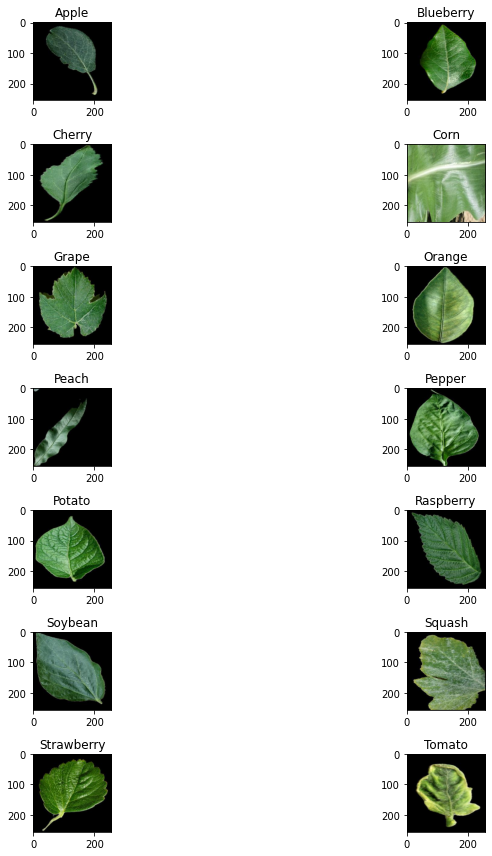

In [ ]:
#i define the labels
labels = ['Apple',       # 0
          'Blueberry',           # 1
          'Cherry',    # 2
          'Corn',              # 3
          'Grape',          # 4
          'Orange',          # 5
          'Peach',   # 6
          'Pepper',             # 7
          'Potato',            # 8
          'Raspberry',         # 9
          'Soybean',             # 10
          'Squash',       # 11
          'Strawberry',  # 12
          'Tomato']        # 13


#THEN WE SHOW SOME EXAMPLES
num_row = 7
num_col = 2

fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 14:
    #walk to obtain images
    class_imgs = next(os.walk('datasetTre/train/{}'.format(labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('datasetTre/train/{}/{}'.format( labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
#quello per il dataset splittato a mano
#ovviamente se rifai lo split questo va cambiato, vedasi esercitazione 4, primo notebook in "Training with and without..."
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255.)  #here i normalize  
valid_generator = ImageDataGenerator(rescale=1/255.) #the dot is not random, lattari inserted it! 
test_generator = ImageDataGenerator(rescale=1/255.)

img_h =256
img_w= 256
batch_size = 8


first_train_gen = train_generator.flow_from_directory(directory=training_dir,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valid_generator.flow_from_directory(directory=validation_dir,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_generator.flow_from_directory(directory=test_dir,
                                             target_size=(img_h, img_w),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=seed)

#anyway the number of images coincide, we have a total of 17728 

Found 15415 images belonging to 14 classes.
Found 2104 images belonging to 14 classes.
Found 209 images belonging to 14 classes.


In [ ]:
#we have a look at the classes labels
print("Assigned labels")
print(first_train_gen.class_indices) 
print()
print("Target classes")
print(first_train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 14)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Label: 11
Class name: Squash


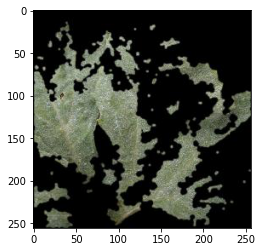

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(first_train_gen)

#TO BE ABLE TO SEE IMAGES HERE YOU NEED TO REMOVE THE RESCALING FACTOR IN THE IMAGEDATAGENERATOR'S CONSTRUCTOR



```
# Questo è formattato come codice
```

#Model definitions


In [ ]:
#5 convo blocks and 1 dense
#really poor performance without augmentation, anyway simone correctly said it is too many convo for such class of images
def build_first_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3), #three by three filters
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


In [ ]:
#3 convo blocks and one dense
#very simple, got 0.51 performance
def build_second_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3), #three by three filters
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#3 convo blocks and one dense
#stride and kernel size modified by simo, 0,27 performance
#probably not enough convo filters
def build_third_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=8,
        kernel_size=(8, 8), #three by three filters
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(8, 8),
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=32,
        kernel_size=(8, 8),
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#3 convo blocks and one dense
#increased filters number wrt to third, performance is 0.34
def build_fourth_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(8, 8), #three by three filters
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(8, 8),
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(8, 8),
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [10]:
#3 convo blocks and one dense
#trial by albe, only changed flatten in global average and increased number of filters at dense + dropout
#performs a little worse than second, gets 0.48
def build_fifth_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3), #three by three filters
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GloablPooling')(conv3)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GloablPoolingDropout')(glob_pooling)
    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(glob_pooling)
    classifier_layer = tfkl.Dropout(0.7, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#done by simo, a lot more filters, probably the stride is too high and the flattening layer generates too many parameters
def build_sixth_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=50,
        kernel_size=(8, 8), #three by three filters
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=100,
        kernel_size=(8, 8),
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=150,
        kernel_size=(8, 8),
        strides = (3, 3),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model 

    

In [ ]:
#done by simo
def build_seventh_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=50,
        kernel_size=(8, 8), #three by three filters
        strides = (2, 2),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=100,
        kernel_size=(12, 12),
        strides = (4, 4),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=150,
        kernel_size=(20, 20),
        strides = (4, 4),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (4, 4)
    )(conv3)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.2, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer2 = tfkl.Dense(units=128, name='Classifier2', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(classifier_layer)
    classifier_layer2 = tfkl.Dropout(0.1, seed=seed)(classifier_layer2)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer2)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model 


In [ ]:
#done by simo
def build_eighth_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=50,
        kernel_size=(3, 3), #three by three filters
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=100,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=150,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.1, seed=seed)(classifier_layer)
    classifier_layer2 = tfkl.Dense(units=64, name='Classifier2', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(classifier_layer)
    classifier_layer2 = tfkl.Dropout(0.1, seed=seed)(classifier_layer2)
    classifier_layer3 = tfkl.Dense(units=32, name='Classifier3', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(classifier_layer2)
    
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer3)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model 

In [ ]:
#3 convo blocks and two dense, with global pooling
#not really good, 0.4867
def build_ninth_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3), #three by three filters
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)


    #flattening and dense, with some dropout
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GloablPooling')(conv3)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GloablPoolingDropout')(glob_pooling)
    classifier_layer1 = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(glob_pooling)
    classifier_layer1 = tfkl.Dropout(0.3, seed=seed)(classifier_layer1)
    classifier_layer2 = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(classifier_layer1)
    classifier_layer2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer2)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer2)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
#3 convo blocks and one dense
#very simple, got 0.51 performance
def build_10th_model(input_shape): 

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3), #three by three filters
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed) #initialized randomly
    )(input_layer)
    pool1 = tfkl.MaxPooling2D( #maxpooling
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)


    #flattening and dense, with some dropout
    flattening_layer = tfkl.Flatten(name='Flatten')(pool4)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.4, seed=seed)(classifier_layer)
    #output with softmax and CHANGE NUMBER OF CLASSES
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)


     # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

#Last Model added

In [ ]:
def build_vgg_model(input_shape, supernet):
  # Use the supernet as feature extractor
#WE DO NOT OPTIMIZE THE LOSS IN THE CONVOLUTIONAL PART
   supernet.trainable = False 

   inputs = tfk.Input(input_shape)

#WE RESIZE INPUT AND THEN THE CONVO PART IS DONE BY SUYPERNET
   x = tfkl.Resizing(256, 256, interpolation="bicubic")(inputs)
   x = supernet(x)

#THEN WE JUST CHAIN IT WITH THE DENSE PART OF THE NETWORK
   x = tfkl.Flatten(name='Flattening')(x)
   x = tfkl.Dropout(0.3, seed=seed)(x)
   x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
   x = tfkl.Dropout(0.3, seed=seed)(x)
   outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
   tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
   tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

   return tl_model

# Without Augmentation


In [ ]:
input_shape = (256, 256, 3)
epochs = 200

first_model = build_first_model(input_shape=input_shape)
first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

In [ ]:
#quoted, unquote in case of need
"""
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='first_model')

# Train the model
history = first_model.fit(
    x = first_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks, #THE RESULT OF OUR FUNCTION IS GIVEN 
).history

"""

"\n# Create folders and callbacks and fit\nnoaug_callbacks = create_folders_and_callbacks(model_name='first_model')\n\n# Train the model\nhistory = first_model.fit(\n    x = first_train_gen,\n    epochs = epochs,\n    validation_data = valid_gen,\n    callbacks = noaug_callbacks, #THE RESULT OF OUR FUNCTION IS GIVEN \n).history\n\n"

In [ ]:
#modelcheckpoint should have saved last model, here we save manually the best weights wrt early stopping

#first_model.save("data_augmentation_experiments/first_model_best_with_manual_split")

In [ ]:
#first_model = tfk.models.load_model("data_augmentation_experiments/first_model_best_with_manual_split")

#non avendo un test set non riesco a vedere la valutazione, forse devo fare un altro split



#Some Augmentation examples


Rotation: {'theta': 28.983886305067962, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': -16, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1.2898388630506796, 'zy': 0.7483589390868994, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

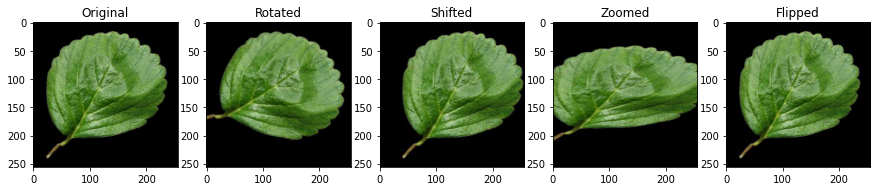

In [ ]:
#CODE TO PRINT SOME AUGUMENTATION EXAMPLES
#CAREFUL! this only works if rescale in the imagedatagenerator that created the set is not used
#fixed (multiplied by 255)



image = next(first_train_gen)[0][4] 

# Create an instance of ImageDataGenerator for each transformation

#WE GENERATE NEW OBJECTS WITH THE DESIDERED TRANSFORMATION
#IT WILL SAMPLE IN THE - AND + RANGE OF THE PARAM WE GIVE
#BY DEFAULT IT PADS WITH ZEROES
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True) #THIS ONE USES A BERNOULLI(?)

# Get random transformations
#WE HAVE A METHOD TO PERFORM A RANDOM GENERATION OF THE DIFFERENT TRANSFORMATIONS
#THE OBJECT IS A TRANFORMATION NOT A TRANSFORMED IMAGE
#IT NEEDS SIZE AND SEED
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
#WE USE A GENERAL GENERATOR AND TELL IT TO PAD WITH CONSTANT VALUES EQUAL TO ZEROES
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
#WE TAKE OUR IMAGE AND APPLY THE TRANSFORMATIONS
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

#WE HAVE A LOOK AT THE RESULT
# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image*255))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated*255))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted*255))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed*255))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped*255))
ax[4].set_title('Flipped')

Transform: {'theta': 86.9516589152039, 'tx': -42, 'ty': -27, 'shear': 0, 'zx': 0.7679964813119569, 'zy': 1.1046354964899536, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


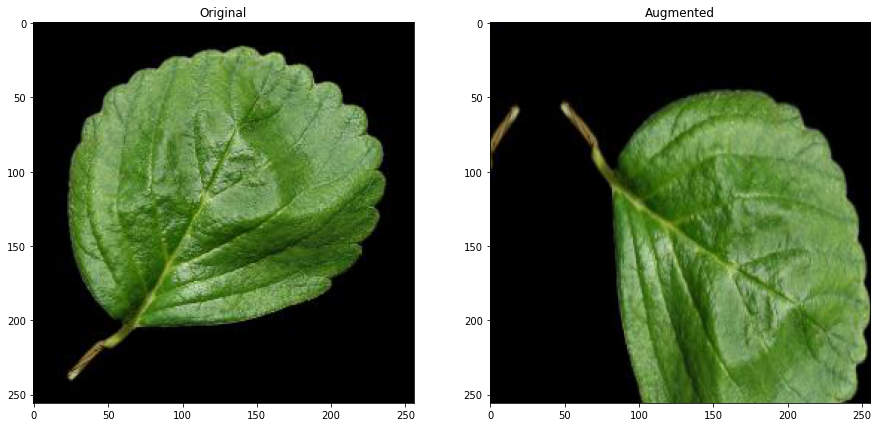

In [ ]:
#CODE TO SEE EXAMPLES OF COMBINED AUGMENTATIONS
#CAREFUL! this only works if rescale in the imagedatagenerator that created the set is not used
#fixed (multiplied by 255)


gen = ImageDataGenerator(rotation_range=90,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True, 
                         fill_mode='reflect') #PERFORMS BETTER THAN ZERO PADDING!

# Get random transformation
t = gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", t)

# Apply the transformation
#WE CAN APPLY AND THEN SEE THE MIX
augmented = gen.apply_transform(image, t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image*255))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented*255))
ax[1].set_title("Augmented")
plt.show()

# With augmentation


In [ ]:
#this is complementary to section Data initialization, it must follow it! 

aug_train_data_gen = ImageDataGenerator(  rotation_range= 40, 
                                          samplewise_center = True,
                                          zoom_range=0.1,
                                          #zca_whitening=True, 
                                          #zca_epsilon=1e-06,
                                          width_shift_range=0.15,
                                          height_shift_range=0.15,
                                          horizontal_flip=True,
                                          rescale=1/255.) # rescale value is multiplied to the image


#THIS PART SHOULD BE THE SAME, ONLY THE CREATION OF THE IMAGEDATAGENERATOR OBJECT CHANGES
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

Found 15415 images belonging to 14 classes.


In [11]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 4.5 MB/s 


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

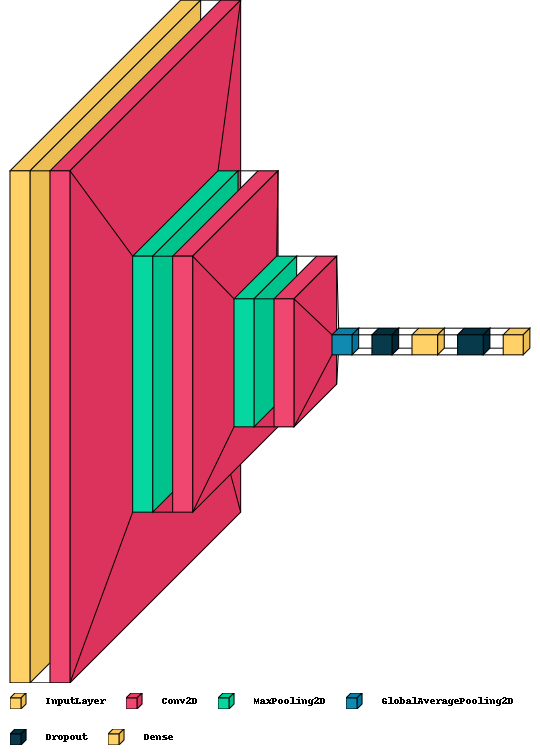

In [12]:
input_shape = (256, 256, 3)
epochs = 30

#you can use the usual function, just change the training set in the fit
aug_model = build_fifth_model(input_shape=input_shape)
aug_model.summary()

visualkeras.layered_view(aug_model, legend=True, spacing=20, scale_xy=2)

In [ ]:
# Create folders and callbacks and fit

aug_callbacks = create_folders_and_callbacks(model_name='1oth_veryaug_model') #CHANGE HERE
"""
# Train the model
history = aug_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

"""

'\n# Train the model\nhistory = aug_model.fit(\n    x = aug_train_gen,\n    epochs = epochs,\n    validation_data = valid_gen,\n    callbacks = aug_callbacks,\n).history\n\n'

In [ ]:
#modelcheckpoint should have saved last model, here we save manually the best weights wrt early stopping

#aug_model.save("data_augmentation_experiments/veryAug_10th_model")

In [ ]:
# Evaluate on test
# Trainined with no data augmentation

#aug_model = tfk.models.load_model("data_augmentation_experiments/veryAug_10th_model")
#model_aug_test_metrics = aug_model.evaluate(test_gen, return_dict=True)


print("Test metrics with data augmentation")
#print(model_aug_test_metrics)

Test metrics with data augmentation


# Transfer Learning


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#WE HAVE TO PREPROCESS DATA AS VGG DOES IT
from tensorflow.keras.applications.vgg16 import preprocess_input

batch_size = 32

aug_train_data_gen = ImageDataGenerator(rotation_range= 40, 
                                        samplewise_center = True,
                                        #zoom_range=0.1,
                                        #zca_whitening=True, 
                                        #zca_epsilon=1e-06,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        horizontal_flip=True,
                                        preprocessing_function=preprocess_input,
                                        fill_mode = 'constant' 
                                        ) # rescale value is multiplied to the image


#THIS PART SHOULD BE THE SAME, ONLY THE CREATION OF THE IMAGEDATAGENERATOR OBJECT CHANGES
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_vgg_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)  #here i normalize  

train_noaug_generator =  ImageDataGenerator(preprocessing_function=preprocess_input,)
valid_generator = ImageDataGenerator( preprocessing_function=preprocess_input,) #the dot is not random, lattari inserted it! 
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,)

img_h =256
img_w= 256

train_vgg_noaug_gen = train_noaug_generator.flow_from_directory(directory=training_dir,
                                                       target_size=(img_h,img_w),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed) 



valid_vgg_gen = valid_generator.flow_from_directory(directory=validation_dir,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

test_vgg_gen = test_generator.flow_from_directory(directory=test_dir,
                                             target_size=(img_h, img_w),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             shuffle=False,
                                             seed=seed) 


Found 15415 images belonging to 14 classes.
Found 15415 images belonging to 14 classes.
Found 2104 images belonging to 14 classes.
Found 209 images belonging to 14 classes.


58900480/58889256 [==============================] - 26s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                             

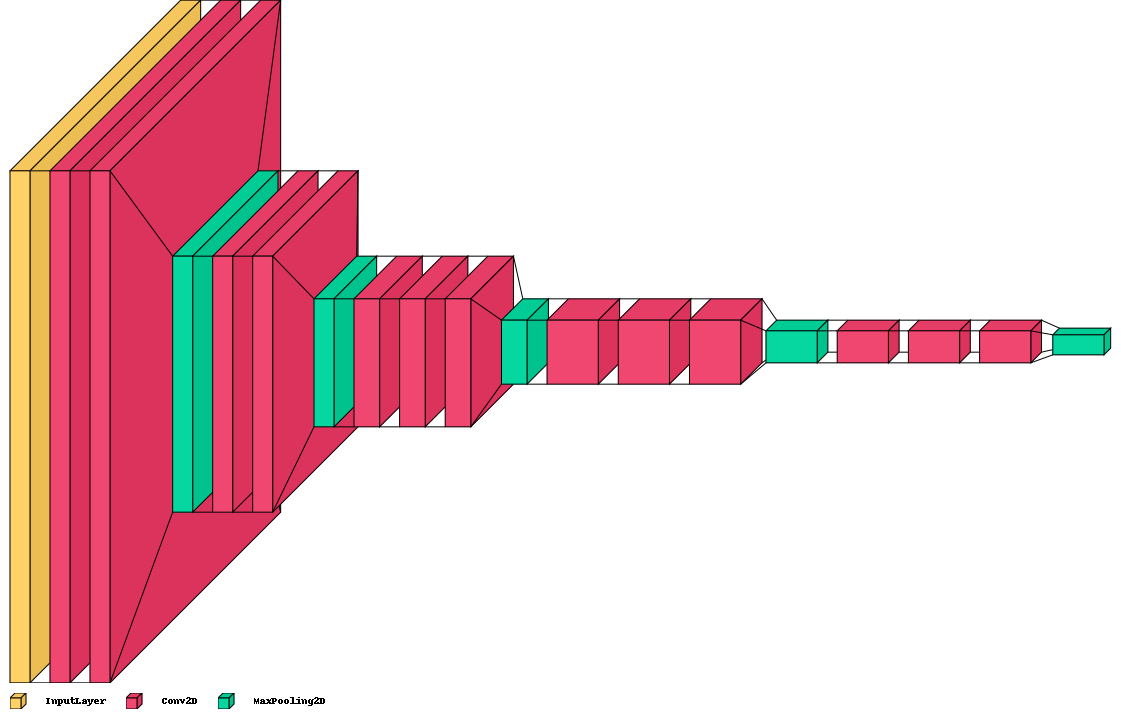

In [ ]:
supernet = tfk.applications.VGG16(
    include_top=False,   #WE DON'T TAKE THE DENSE PART, WE ARE GONNA TRAIN IT
    weights="imagenet",   #WE INITIALIZE THE WEIGHTS AS THE IMAGENET ONES
    input_shape=(256,256,3) #SHAPE OF NEW INPUT
)

supernet.summary()
tfk.utils.plot_model(supernet)
visualkeras.layered_view(supernet, legend=True, spacing=20, scale_xy=2)

In [ ]:
# Use the supernet as feature extractor
#WE DO NOT OPTIMIZE THE LOSS IN THE CONVOLUTIONAL PART
supernet.trainable = False 

inputs = tfk.Input(shape=(256,256,3))

gaussian = tfkl.GaussianNoise(stddev=0.01, seed=seed) (inputs)

#WE RESIZE INPUT AND THEN THE CONVO PART IS DONE BY SUYPERNET
x = tfkl.Resizing(256, 256, interpolation="bicubic")(gaussian)
x = supernet(x)


#THEN WE JUST CHAIN IT WITH THE DENSE PART OF THE NETWORK
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.BatchNormalization() (x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 256, 256, 3)      0         
 se)                                                             
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                                 
 dropout_4 (Dropout)         (None, 32768)             0         
                                                             

In [ ]:
aug_callbacks =create_folders_and_callbacks(model_name='tl_model_potenziato')
# Train the model

tl_history = tl_model.fit(
    x = train_vgg_gen,
    batch_size = 32,
    epochs = 25,
    validation_data = valid_vgg_gen,
    callbacks = aug_callbacks
).history


Epoch 1/25
482/482 [==============================] - 6709s 14s/step - loss: 0.5840 - accuracy: 0.8374 - val_loss: 0.3152 - val_accuracy: 0.9278
Epoch 2/25
482/482 [==============================] - 3600s 7s/step - loss: 0.3072 - accuracy: 0.9137 - val_loss: 0.2285 - val_accuracy: 0.9501
Epoch 3/25
127/482 [======>.......................] - ETA: 50:18 - loss: 0.2403 - accuracy: 0.9311

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-54f3a56cc8a2>", line 9, in <module>
    callbacks = aug_callbacks
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1216, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 910, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 942, in _call
    return self._stateless_fn(*ar

KeyboardInterrupt: ignored

In [ ]:
tl_model.save("data_augmentation_experiments/tl_model_potenziato")

# CORRECTED FINE TUNING

In [ ]:
ft_model = tfk.models.load_model('data_augmentation_experiments/tl_model_potenziato')
ft_model.summary()

In [ ]:
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [ ]:
# Fine-tune the model
aug_callbacks = create_folders_and_callbacks(model_name="ft_pot")
ft_history = ft_model.fit(
    x = train_vgg_gen,
    batch_size = 32,
    epochs = 25,
    validation_data = valid_vgg_gen,
    callbacks = aug_callbacks
).history

In [ ]:
ft_model.save("data_augmentation_experiments/ft_potenziato")

In [ ]:
"""
input_shape = (256,256,3)
epochs = 20
ft_model = build_vgg_model(input_shape, supernet)
ft_model.summary()
aug_callbacks = create_folders_and_callbacks(model_name='ft_aug_yespreprocess_more_data_model')
visualkeras.layered_view(ft_model, legend=True, spacing=20, scale_xy=2)
"""

In [ ]:
"""
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
print("\n\n\n\n\nAFTER")

#we make so only last convo part is trainable (and dense we added obv) 
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()
"""

In [ ]:
 # Train the model
"""
ft_history = ft_model.fit(
    x = train_vgg_gen, #SIMO CAMBIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
    batch_size = 32,
    epochs = epochs,
    validation_data = valid_vgg_gen,
    callbacks = aug_callbacks
).history
"""

In [ ]:
#ft_model.save("data_augmentation_experiments/ft_aug_yespreprocess_more_datamodel")

In [ ]:
"""
ft_model = tfk.models.load_model("data_augmentation_experiments/ft_noaug_nopreprocess_model")
ft_model_test_metrics = ft_model.evaluate(test_vgg_gen, return_dict=True)


print("Test metrics with data augmentation")
print(ft_model_test_metrics)
"""

# See some results


In [ ]:
# Predict the test set with the CNN
"""
predictions = ft_model.predict(test_vgg_gen)
predictions.shape
"""

In [ ]:
# Plot the target images and the predictions
"""
batch = next(test_gen)
image = batch[0]
image_resized = image[0, :, :, 0]
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(image_resized*255)
ax1.set_title('True label: '+labels[np.argmax(batch[1])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()
"""

In [ ]:
# Compute the confusion matrix
"""
for i in range(1,10) :
    next_batch = next(test_vgg_gen)
    predictions = ft_model.predict(next_batch[0])
    predictions.shape
    cm = confusion_matrix(np.argmax(next_batch[0], axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(test_gen, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

# Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
"""

# Visualize activations

In [ ]:
aug_model = tfk.models.load_model("data_augmentation_experiments/first_model_best")
layers = [layer.output for layer in aug_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=aug_model.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image

#I USE THE PREDICT ON A FOUR DIMENSIONAL VECTOR
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)
#SOME FILTERS ARE NOT LEARNED, SOME OTHERS DETECT EDGES
#WE CAN SEE AT DIFFERENT DEPTHS!

#TensorBoard


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir data_augmentation_experiments/ft_noaug_nopreprocess_model_Nov21_13-18-05